In [42]:
# full import 

# data loading
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

# files handling
import os
import tarfile
import urllib

# data cleaning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# create pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# models evaluate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# hyperparameter tweaking
from sklearn.model_selection import GridSearchCV

# to compute 95% confidence interval
from scipy import stats

UsageError: Line magic function `%` not found.


# In this Chapter


You will go through an example project end to end, pretending to be a recently hired data scientist in a real estate company.


Here are the main steps you will go through
1. Look at the big picture
2. Get the Data
3. Discover and Visualize the data to gain insights
4. Prepare the Data for Machine Learning algorithms
5. Select a model and train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor, and maintain your system

---

# Working with Real Data


when you are learning about Machine Learning, it is best to actually experiment with real-world data, not just artificial datasets.
Fortunately, there are thousands of open datasets to choose from, ranging across all sorts of domains.


Here are a few places you can look to get data
- Popular open data repositories:
    - [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml)
    - [Kaggle Datasets](https://www.kaggle.com/datasets)
    - [Amazon's AWS datasets](https://registry.opendata.aws)
- Meta portals (they list open data repositories):
    - http://archive.ics.uci.edu/ml
    - http://opendatamonitor.eu/
    - http://opendatamonitor.eu/
- Other pages listing many popular open data repositories:
    - [Wikipedia’s list of Machine Learning datasets](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research)
    - [Quora.com question](https://www.quora.com/Where-can-I-find-large-datasets-open-to-the-public)
    - [Datasets subreddit](https://www.reddit.com/r/datasets)

---

# Look at the Big Picture


The first task you are aksed to perform is to build a model of housing prices in California using the California cencus data.
This data has metrics such as the population, median income, median housing price, and so on for each block group (or district) in California.


> Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics

---

## Frame the Problem

The first question to ask is what exactly is the business objective; building a model is probably not the goal. How does the company expect to use and benefit from this model?
>> This is important because it will determine how you frame the problem, what algorithms you will select, what performance measure you will use to evaluate your model, and how much effort you should spend tweaking it.


You boss answers that your model's output (a prediction of a district's median housing price) will be fed to another Machine Learning system, along with many other *signals*. This downstream system will determine whether it is worth investing in a given area or not.
>> Getting this right is critical, as it directly affects revenue.

---

### Pipelines


A sequence of data processing **components** is called a data **pipeline**. 
Pipelines are very common in Machine Learning systems, since there is a lot of data manipulate and many data transformations to apply.


- *Components typically run asynchronously*: Each components pulls in a large amount of data, process it, and spits out the result in another data store, and then some time later, the next component in the pipeline pulls this data and spits out its own output, and so on. 


- *Each component is fairly self-contained*: The interface between components is simply the data store. This makes the system quite simple to grasp (with the help of a data flow graph), and different teams can focus on different components. 
    - Moreover, if a component breaks down, the downstream components can often continue to run normally (at least for a while) by just using the last output from the broken component. This makes the architecture quite robust.
    - On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall

---

## Select a Performance Measure


Your next step is to **select a performance measure**. A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.


>$RMSE(X, h) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(x^{(i)})-y^{(i)}})^2}$ 


**Notations**:
- $m$: The number of instances in the dataset you are measuring the RMSE on.
    - For example, if you are evaluating the RMSE on a validation set of 2000 district, then $m=2000$
- $x^{(i)}$: A vector of all the features values (excluding the label) of the $i^{th}$ instance in the dataset.
- $y^{(i)}$: The $i^{th}$ instance's label (the desired output value for that instance).
- $X$: A matrix containing all features values (excluding labels) of all instances in the dataset. There is one row per instance and the $i^{th}$ row is equal to the transpose of $x^(i)$, noted $(x^{(i)})^T$.
- $h$: Your system prediction function, also called **hypothesis**. When your system is given an instance's feature vector $x^{(i)}$, it outputs a predicted value $\hat{y}^{(i)} = h(x^{(i)})$ for that instance.
- $RMSE(X,h)$: The cost function measured on the set of examples using your hypothesis $h$. 

---

## Check the Assumptions


Lastly, it is good practice to list and verify the assumptions that were made so far; this can catch serious issues early on.


For example, the district prices that your system outputs are going to be fed into a downstream Machine Learning system, and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g. "cheap", "medium" or "expensive") and then uses those categories instead of the prices themselves?.
In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that's so, then the problem should have been framed as a classification task, not a regression task. You don't want to find this out after working on a regression system for months.

---

# Get the Data


It's time to get your hands dirty. Don't hesitate to pick up your laptop and walk through the following code examples in a Jupyter notebook. 


The full jupyter notebook is available at: https://github.com/ageron/handson-ml2

---

## Create the Workspace


You need to have Python installed. You can get it at: https://www.python.org/


It is also recommended to use a virtual environment (like `Anaconda` or packages like `virtualenv`).


Installing the required packages.

---

## Download the Data

In [43]:
# here we create a small function to fetch the data

import os 
import tarfile 
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    '''creates datasets/housing directory in your workspace, 
    downloads the housing.tgz file, and extracts it in this directory'''
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# let's load the data using pandas
# we can also create a small function to load the data

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    '''returns a pandas DataFrame object containing all the data'''
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

In [44]:
# let's take a look at the top five rows using the head() method

fetch_housing_data()
housing = load_housing_data() # load the data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [45]:
# the info() method is useful to get a quick description of the data
# in particular the total number of rows, and each attribute's type and number of non-null values

housing.info()

# notice that the 'total_bedrooms attribute has only 20433 non-null values
# meaning that 207 districts are missing this feature. We will need to take care of this later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [46]:
# all attributes are numerical, except the 'ocean_proximity' field
# you can find out what categories exist and how many districts belong to each category by using the value_counts() method

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [47]:
# let's look at the other fields
# the describe() method shows a summary of the numerical attributes

housing.describe()

# the count, mean, min, and max rows are self-explanatory
# the std row shows the standard deviation:
#   # which measures how dispersed the values are
# the 25%, 50%, 75% rows shows the corresponding percentiles:
#   # a percentile indicates the value below which a given percentage of observations in a group of observations falls
#   # these are often called:
#   #   # 25%: 25th percentile (or 1st quartile)
#   #   # 50%: median
#   #   # 75%: 75th percentile (or 3rd quartile)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


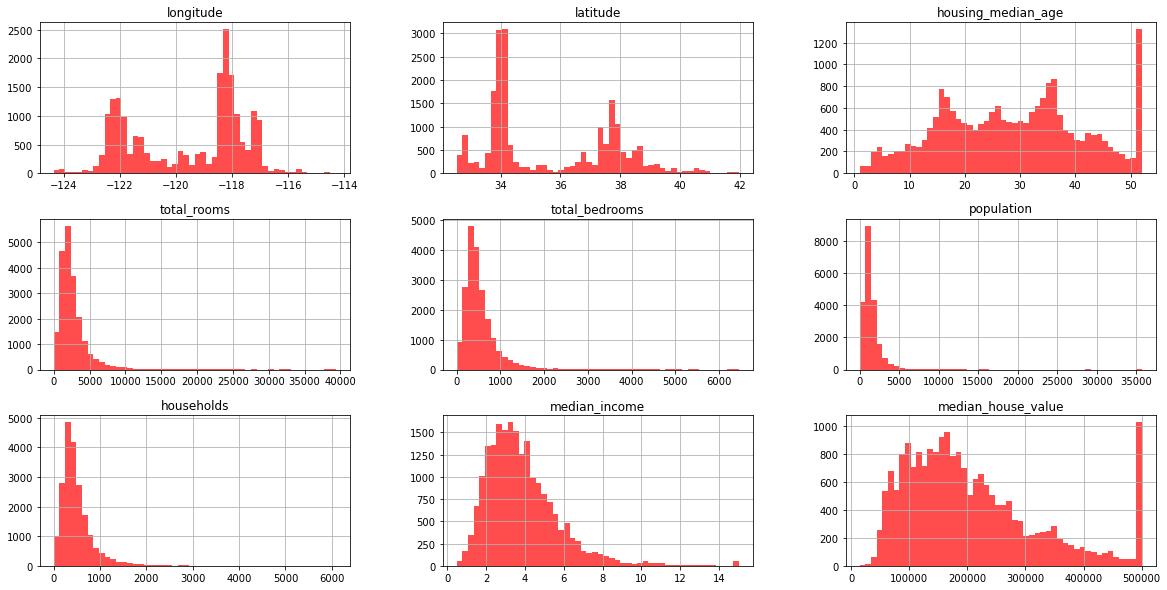

In [48]:
# another quick way to get a feel of the type of data you are dealing with 
# is to plot a histogram for each numerical attribute
#   # a histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis)
# you can either plot this one attribute at a time
# or you can call the hist() method on the whole dataset
# and it will plot a histogram for each numerical attribute

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 10), color='red', alpha=0.7)
plt.show()

In [49]:
# notice a few things in these histograms:
# 1.
# the 'median_income' attribute does not look like it is expressed in US dollars (USD)
# the data has been capped at 15 (for higher median incomes) and at 0.5 (for lower median incomes)
# the number represents roughly tens of thousands of dollars (10000 USD)
# 2.
# the 'housing median_age' and the 'median_house_value' were also capped
# the latter may be a serious problem since it is your target attribute (your labels)
# your machine learning algorithms may learn that prices never go beyond that limit
# 3.
# these attributes have very different scales
# we will discuss this later when we explore feature scaling
# 4. 
# many histograms are 'tail heavy': they extend much farther to the right of the median than to the left
# this may make it a bit harder for some Machine Learning algorithms to detect patterns
# we will try transforming these attributes later on to have more bell-shaped distributions

## Create a Test Set

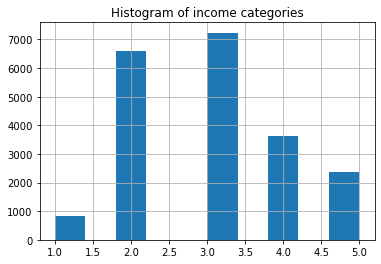

In [50]:
# read the book for the full description
# here we shows two ways from the sklearn.model_selection module

# random sampling using train_test_split() 
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# since you want to ensure that the test set is representative of the various categories of incomes in the whole dataset
# you need to create an income category attribute (because median income is a continuous numerical attribute)
import numpy as np
np.random.seed(42) # set the random seed so code runs the same everytime (for educational purpose)
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0, 1.5, 3, 4.5, 6, np.inf], 
                               labels=[1, 2, 3, 4, 5])
# plot the newly added attribute
fig, ax = plt.subplots(1, 1)
housing["income_cat"].hist(ax=ax)
ax.set_title("Histogram of income categories")

# stratified sampling using StratifiedShuffleSplit (will be used in this chapter)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# now you should remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [51]:
# so far you have only taken a quick glance at the data 
# to get a general understanding of the kind of data you are manipulating
# now the goal is to go a little bit more in depth

# first, make sure you have put the test set aside and you are only exploring the training-set
# let's create a copy so you can play with it without harming the training-set

housing = strat_train_set.copy()

## Visualizing Geographical Data

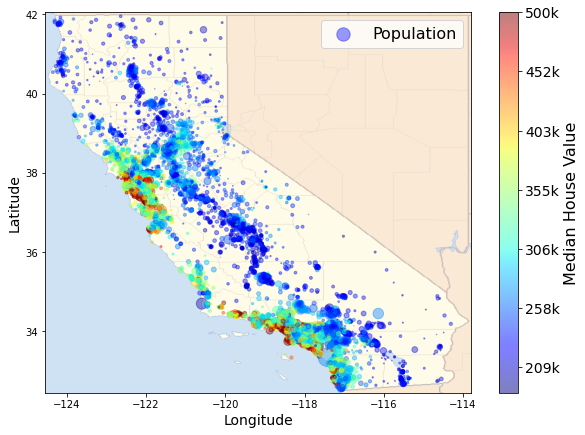

In [52]:
# since there is geographical information (latitude and longitude)
# it is a good idea to create a scatterplot of all districts to visualize the data
import matplotlib.image as mpimg

# Download the California image
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))


# create the plot
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10, 7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["{}k".format(round(v/1000))
                        for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

## Looking for Correlations

In [53]:
# since the dataset is not too large
# you can easily compute the 'standard correlation coefficient' (also called Pearson's r) between every pair of attributes
# using the corr() method

corr_matrix = housing.corr()

# now let's look at how much each attribute correlates with the median_house_value
corr_matrix["median_house_value"].sort_values(ascending=False)

# the correlation coefficient ranges from -1 to 1
# when it is close to 1, it means that there is a strong positive correlation
# when it is close to -1, it means that there is a strong negative correlation
# when it is close to 0, it means that there is no linear correlation

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

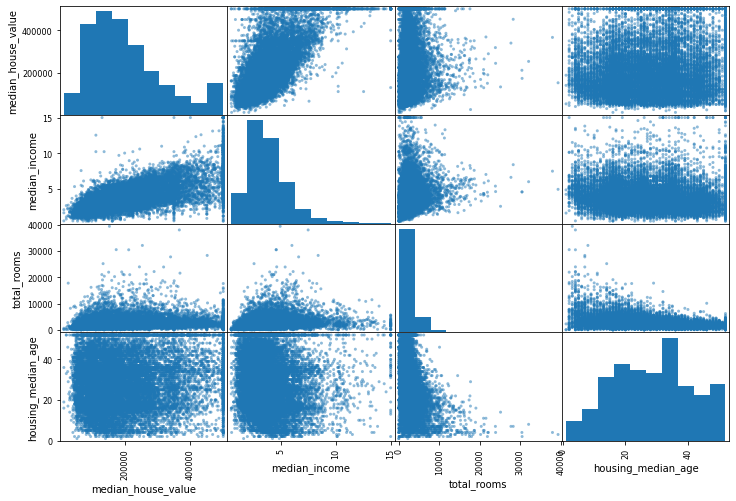

In [54]:
# another way to check for correlation between attributes is to use pandas' scatter_matrix() function
# which plots every numerical attribute against every other numerical attribute

# since you have 11 numerical attributes, you would get 121 plots, which would not fit a page
# so let's just focus on a few promising attributes that seem most correlated with the median_house_value

from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
_ = scatter_matrix(housing[attributes], figsize=(12, 8))

# the main diagonal would be full of straight lines if pandas plotted each variable against itself
# which would not be very useful
# so instead, pandas display a histogram of each attribute (other options are available; check the pandas' documentation)

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

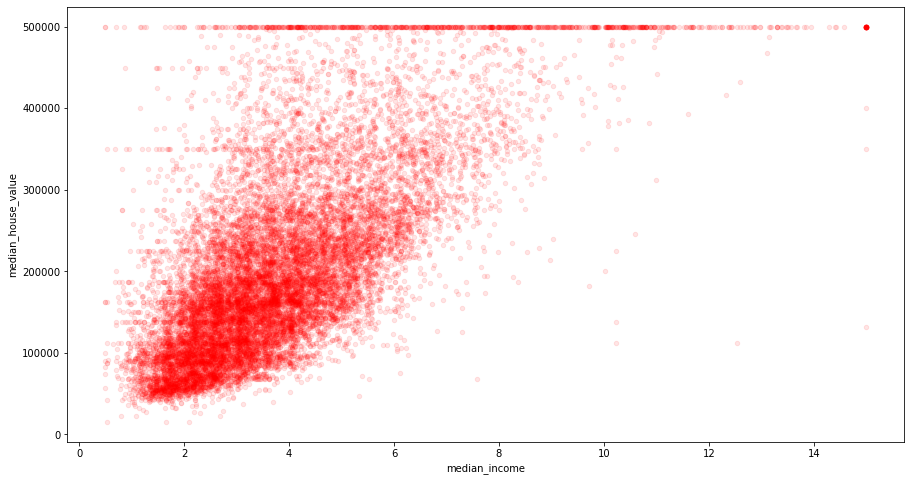

In [55]:
# the most promising attribute to predict the median_house_value is the median_income
# so let's zoom in on their correlation scatterplot
housing.plot(kind='scatter', 
             x='median_income', y='median_house_value', 
             alpha=0.1, color='red', figsize=(15, 8))

# this plot reveal a few things:
# first, the correlation is indeed very strong, you can clearly see the upward trend and the the points are not too dispersed
# second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500k
# but this plot also reveals other less obvious straight lines: $450k, $350k, $280k, and a few more below that
# you may try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks

## Experimenting with Attribute Combinations

In [56]:
# hopefully the previous section give you an idea of a few ways you can explore the data and gain insights
# you identified a few data quirks that you may want to clean up before feeding the data to a ML algorithm
# you found interesting correlations between attributes, in particular with the target attribute
# you noticed that some attributes have a tail-heavy distribution, so you may want to transform them

# one last thing you may want to do before actually preparing the data for ML algorithms
# is to try out various attribute combinations

# examples:
# the total_rooms is not very useful if you don't know how many households there are 
# what you really want is the number of rooms per households
# similarly, total_bedrooms is not very useful (you may want to compare it the total_rooms)
# and the population per households also seems like an interesting attribute combination to look at
# let's create these new attributes
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [57]:
# now let's look at the correlation matrix again
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

# the new bedrooms_per_room attribute is much more correlated with the median_house_value than total_rooms or total_bedrooms
# the lower bedrooms/room ratio houses tend to be more expensive
# the rooms_per_household is also more informative than total_rooms
# the larger the houses (more rooms) the more expensive they are

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms


It's time to prepare the data for your Machine Learning algorithms. 
Instead of just doing this manually, you should write functions to do that, for several good reasons:

- This will allow you to reproduce these transformations easily on any dataset
- You will gradually build a library of transformation functions that you can reuse in future projects
- You can use these functions in your live system to transform the new data before feeding it to your algorithms
- This will make it possible for you to easily try various transformations and see which combination of transformations works best

In [58]:
# but first, let's revert to a clean dataset
# and separate the predictors and the labels 

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# note that drop() creates a copy of the data and does not affect strat_train_set

## Data Cleaning


Most Machine Learning algorithms cannot work with missing features, so let's create a few functions to take care of them.


You have 3 options:

- Get rid of the corresponding districts
- Get rid of the whole attribute
- Set the values to some value (zero, the mean, the median, etc.)

You noticed earlier that the total_bedrooms attribute has some missing values. <br>
You can clean them easily using DataFrame's **dropna()**, **drop()**, and **fillna()** methods:

- option1: `housing.dropna(subset=["total_bedrooms"])`
- option2: `housing.drop("total_bedrooms", axis=1)`
- option3: <br>
`median = housing["total_bedrooms"].median()` <br>
`housing["total_bedrooms"].fillna(median, inplace=True)`

In [59]:
# scikit-learn provides a handy class to take care of missing values: SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# since the median can only be computed on numerical attributes
# we need to create a copy of the data without the ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)

# now you can fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

# the imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [60]:
# now you can use this "trained" imputer to transform the training set
# by replacing missing values by the learned medians 

X = imputer.transform(housing_num) # the result is a plain Numpy array containing the transformed features

# if you want to put it back into a pandas' DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Scikit-Learn Design


Scikit-Learn API is remarkably well desinged. The [main design principles](https://homl.info/11) are:


- **Consistency**. All objects share a consistent and simple interface:
    - **Estimators**: 
        - Any object that can estimate some parameters based on a dataset is called an *estimator*. 
        - The estimator itself is performed by the **fit()** method, and it takes only a dataset as a parameter (or two for supervised learning; the second dataset contains the labels). 
        - Any other parameter needed to guide the estimator process is considered a hyperparameter, and it must be set as an instance variable (generally via a constructor parameter).
    - **Transformers**: 
        - Some estimators can also transform a dataset; these are called *transformers*. 
        - Once again, the API is quite simple: the transformation is performed by the **transform()** method with the dataset to transform as a parameter. 
        - It returns the transformed dataset. This transformation generally relies on the learned parameters. 
        - All transformers also have a convenience method called **fit_transform()** that is equivalent to calling **fit()** and then **transform()** (but sometimes **fit_transform()** is optimized and runs much faster).
    - **Predictors**: 
        - Finally, some estimators are capable of making predictions given a dataset; they are called *predictors*. 
        - A predictor has a **predict()** method that takes a dataset of new instances and returns a dataset of corresponding predictions. 
        - It also has a **score()** method that measures the quality of the predictions given a test set (and the corresponding labels in the case of supervised learning algorithms).
- **Inspection**. 
    - All the estimator's hyperparameters are accessible directly via public instance variables. 
    - All the estimator's learned parameters are also accessible via public instance variables with an underscore suffix.
- **Nonproliferation of classes**. 
    - Datasets are represented as Numpy arrays or SciPy sparse matrices, instead of homemade classes. 
    - Hyperparameters are just regular Python strings or numbers
- **Composition**. 
    - Existing building blocks are reused as much as possible. For example, it is easy to create a **Pipeline** estimator from an arbitrary sequence of transformers followed by a final estimator, as we will see.
- **Sensible defaults**. 
    - Scikit-Learn provides reasonable default values for most parameters, making it easy to create a baseline working system quickly.

---


## Handling Text and Categorical Attributes

In [61]:
# earlier we left out the categorical attribute ocean_proximity 
# because it is a text attribute so we cannot compute its median
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [62]:
# most Machine Learning algorithms prefer to work with numbers anyways
# so let's convert these categories from text to numbers
# for this we can use scikit-learn's OrdinalEncoder class
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])
print('------------------------------------')
# you can get the list of categories using the 'categories_' instance variable
print(ordinal_encoder.categories_)

[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]
------------------------------------
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [63]:
# one issue with this representation is that 
# ML algorithms will assume that two nearby values are more similar than two distant values
# this may be fine in some cases (e.g. for ordered categories like "bad", "average", "good")
# but it is not the case for ocean_proximity column
# to fix this issue, a common solution is to use 'one-hot-encoding'
# scikit-learn provides a OneHotEncoder class to do this
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# notice that the output is a Scipy sparse matrix (to save memories when saving a feature with multiple categories)
print(type(housing_cat_1hot))
print('------------------------------------')
# you can use it like a normal 2D array
# but if you really want to convert it to a Numpy array, just call the toarray() method
print(housing_cat_1hot.toarray())
print('------------------------------------')
# once again, you can get the list of categories using the encoder's 'categories_' instance variable
print(cat_encoder.categories_)
print('------------------------------------')

<class 'scipy.sparse._csr.csr_matrix'>
------------------------------------
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
------------------------------------
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
------------------------------------


## Custom Transformers

In [64]:
# although scikit-learn provides many useful transformers
# you will need to write your own for tasks such as custom clean up operations or combining specific attributes
# you will want your transformer to work seamlessly with scikit-learn functionalities (such as pipelines)
# and since scikit-learn relies on duck typing (not inheritance)
# all you need to create a class and implement three methods: 
#   # fit() (returning self)
#   # transform()
#   # fit_transform(): you can get by simply adding TransformerMinxin as a base class
# also, if you add BaseEstimator as a base class (and avoid *args and **kwargs in your constructor)
# you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning


# for example, here is a small transformer class that adds the combined attributes we discussed earlier
from sklearn.base import BaseEstimator, TransformerMixin

# columns index
room_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, room_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attr = attr_adder.transform(housing.values)

## Feature Scaling

One of the most important transformations you need to apply to your data is 'feature scaling'. With few exceptions, ML algorithms don't perform well when the input numerical attributes have very different scales.


There are two common ways to get all attributes to have the same scale: 
- **Min-max scaling** (or *normalization*): 
    - Values are shifted and rescaled so that they end up ranging from 0 to 1. 
    - We do this by subtracting the min value and dividing by the max minus the min. 
    - Scikit-Learn provides a transformer called **MinMaxScaler** for this. 
    - it has a *feature_range* hyperparameter that lets you change the range if you don't want 0-1 for some reason.
- Standardization: 
    - First it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. 
    - Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms.
    - However, standardization is much less affected by outliers. Scikit-learn provides a transformer called **StandardScaler** for standardization.

---

## Transformation Pipelines

In [65]:
# as you can see, there are many data transformation steps that need to be executed in the right order
# scikit-learn provides the 'Pipeline' class to help with such sequences of transformations

# the Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps
# all but the last estimator must be transformers (i.e. they must have a fit_transform() method)
# the name can be anything you like (as long as they are unique and don't contain double underscore "__")
# they will come in handy later for hyperparameter tuning

# when you call the pipeline's fit() method
# it calls fit_transform() sequentially on all transformers, passing the output of each call as parameter to the next call
# until it reaches the final estimator, for which it just call the fit() method

# here is a small pipeline for the numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# the pipeline exposes the same methods as the final estimator
# in this example, the last estimator is a StandardScaler (a transformer)
# so the pipeline has a fit_transform() method
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [66]:
# so far, we have handled the categorical and numerical columns separately 
# it would be more convenient to have a single pipeline able to handle all columns
# scikit-learn has the 'ColumnTransformer' for this purpose, and it works great with pandas' DataFrame
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), 
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [67]:
# the good news is that thanks to all these previous steps, things are now going to be much simpler than you think
# let's first train a LinearRegression model, like we did in the previous chapter
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [68]:
# done! You now have a working Linear Regression model
# let's try it out on a few instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", list(lin_reg.predict(some_data_prepared)))
print("Labels:", list(some_labels))

Predictions: [85657.90192014375, 305492.607374877, 152056.4612245569, 186095.70946094388, 244550.67966088964]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [69]:
# it works, although the predictions are not exactly accurate
# let's measure this regression model's RMSE on the whole training set 
# using scikit-learn's mean_square_error() function
# Note: since scikit-learn 0.22, you can get the RMSE directly by calling mean_square_error() function with 'squared=False'

from sklearn.metrics import mean_squared_error
housing_predictor = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictor)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# this is better than nothing but clearly not a great score
# most districts' median_housing_values range between $120k and $265k
# so a typical prediction error of $68,628 is not very satisfying
# this is an example of a model underfitting the training data
# when this happens it can mean that the features do not provide enough information to make good predictions
# or that the model is not powerful enough

68627.87390018745

In [70]:
# as we saw in the previous chapter
# the main ways to fix underfitting are:
#   # select a more powerful model
#   # feed the training algorithm with better features 
#   # reduce the constraints on the model


# let's train a DescisionTreeRegressor
# this is a powerful model, capable of finding complex nonlinear relationships in the Data
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [71]:
# now that the model is trained, let's evaluate it on the training set

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# no error at all? Could this model really be absolutely perfect?
# of course, it is more likely that the model has badly overfitting the data
# how can you be sure?
# as we saw earlier, you don't want to touch the test set until you are ready to launch a model you are confident about
# so you need to use part of the training set for training, and part for model validation

0.0

## Better Evaluation Using Cross-Validation

In [72]:
# one way to evaluate the Decision Tree model
# would be to use the train_test_split() function to split the training set into a smaller training set and a validation set
# then train your models against the smaller training set and evaluate them against the validation set

# a great alternative is to use scikit-learn's 'K-fold-cross-validation' feature

# the following code randomly splits the training set into 10 distinct subsets called 'folds'
# then it trains and evaluates the Decision Tree model 10 times
# picking a different fold for evaluation everytime, and training on the other 9 folds
# the result is an array containing 10 evaluation scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# scikit-learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better)
# so the scoring function is actually the opposite of the MSE (i.e. a negative value)
# which is why the preceding code computes (-scores) before computing the square root

# let's look at the result
def display_scores(scores):
    print("Scores:", list(scores))
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
display_scores(tree_rmse_scores) # not to accurate now, is it!

Scores: [71986.79997823165, 70252.8810455081, 68611.42325630334, 71334.36849238344, 69131.70964219893, 78389.57726431347, 69625.85465549979, 72191.66502447534, 69113.32575130805, 70089.64365944728]
Mean: 71072.72487696694
Standard Deviation: 2703.5007555625007


In [73]:
# let's compute the same score for the Linear Regression model just to be sure
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# this proves that the Decision Tree model is overfitting so badly
# that it performs worse than the Linear Regression model

Scores: [71762.76364394205, 64114.99166359101, 67771.17124355724, 68635.19072082045, 66846.14089488103, 72528.03725384997, 73997.08050232663, 68802.33629334369, 66443.28836883698, 70139.79923955735]
Mean: 69104.07998247063
Standard Deviation: 2880.328209818067


In [74]:
# let's try one last model now: the RandomForestRegressor
# as we will see in chapter 7
# Random Forests work by training many Decision Trees on random subsets of the features
# then averaging out the predictions
# building a model on top of many other models is called 'Ensemble Learning'
# and it is often a great way to push ML algorithms even further

# it is essentially the same as for the other model
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# let's check our model
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse # score on the training set

18657.77808174522

In [75]:
# Note: this cell is going to take quite some time to compute. Be patient!

# let's evaluate the result using cross-validation 
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                    scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores) # this score is much better

# however, note that the score on the training set is still much lower than on the validation sets
# meaning that the model is still overfitting the training set
# possible solutions for overfitting are:
#   # simplify the model 
#   # constrain it (i.e. regularize it)
#   # get a lot more training data

Scores: [51211.30051482123, 48937.38627240692, 46834.055974423354, 52067.85568445422, 47713.00249820705, 51932.459383213936, 52315.483355985816, 49593.73432223905, 48616.67030384386, 53606.33228958466]
Mean: 50282.82805991801
Standard Deviation: 2133.2185520063504


### Save your models


you should save every model you experiment with so you can comeback easily to any model you want. Make sure you save both the hyperparameters and the trained parameters as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make.


you can easily save scikit-learn models by using: 
 - python's **pickle** module
 - **sklearn.externals.joblib** (which is more efficient at serializing large Numpy arrays)



`from sklearn.externals import joblib` <br>
> Here's how you save your model: <br>
`joblib.dump(my_model, "my_model.pkl")`


> Here's how you load your model: <br>
`my_model_loader = joblib.load("my_model.pkl")`

---

# Fine-Tune your Model


Let's assume that you now have a shortlist of promising models. You now need to fine-tune them. Let's look at a few ways you can do that

## Grid Search

In [76]:
# one way to do that would be to fiddle with the hyperparameter manually 
# unitl you find a great combination of hyperparameter values
# this would be very tedious work, and you may not have time to explore many combinations

# instead, you should get scikit-learn's 'GridSearchCV' to search for you
# all you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out
# and it will evaluate all the possible combinations of hyperparameters values using cross-validation

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# when you have no idea what value a hyperparameter should have
# a simple approach is to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained search)

# this param_grid tells scikit-learn to 
# first evaluate 3x4=12 combinations of n_estimator and max_features hyperparameter values specified in the first dict
# then try 2x3=6 combinations of hyperparameter values in the second dict, but this time boostrap is set to False instead of True
# (you don't need to worry about what these hyperparameters mean for now; they will be explained later)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [77]:
# all in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values
# and each will train each model five times (cv=5)
# in other words, there will be 18 x 5 = 90 rounds of training!
# when it's done, you can get the best combination of parameters like this
print(grid_search.best_params_)

# you can also get the best estimator directly
print(grid_search.best_estimator_)

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(max_features=6, n_estimators=30)


In [78]:
# and of course, the evaluation scores are also available
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63137.58633995604 {'max_features': 2, 'n_estimators': 3}
55413.90299875251 {'max_features': 2, 'n_estimators': 10}
52803.76420030709 {'max_features': 2, 'n_estimators': 30}
60631.96425252134 {'max_features': 4, 'n_estimators': 3}
52752.06314518182 {'max_features': 4, 'n_estimators': 10}
50482.86781364942 {'max_features': 4, 'n_estimators': 30}
58905.994300485036 {'max_features': 6, 'n_estimators': 3}
52195.587612848045 {'max_features': 6, 'n_estimators': 10}
50208.769656494296 {'max_features': 6, 'n_estimators': 30}
57989.29276423087 {'max_features': 8, 'n_estimators': 3}
52836.65387167307 {'max_features': 8, 'n_estimators': 10}
50298.549930737216 {'max_features': 8, 'n_estimators': 30}
62380.00810786394 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54100.26924686264 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59733.0686748757 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52254.49497227341 {'bootstrap': False, 'max_features': 3, 'n_estimators':

## Randomized Search

In [79]:
# the grid search is fine when you are exploring relatively few combinations
# but when the 'search space' is large, it is often preferable to use 'RandomizedSearchCV' instead
# this class can be used in much the same way as the GridSearchCV class
# but instead of trying out all possible combinations, it evaluates a given number of random combinations 
# by selecting a random value for each hyperparameter at every iteration
# this approach has two main benefits:
#   # if you let the randomized search run for, say, 1000 iterations, 
#   #   # this approach will explore 1000 different values for each hyperparameter 
#   #   # (instead of just a few value per hyperparameter with grid search approach)
#   # you have more control over the computing budget you want to allocate to hyperparameter search
#   #   # simply by setting the number of iterations

## Ensemble Methods

In [80]:
# another way of fine-tune your system is to try to combine the models that perform best
# the group (or "ensemble") will often perform better than the best individual model
# (just like Random Forests perform better than the individual Decision Trees they rely on)
# especially if the individual models make very different types of errors
# we will cover this topic in more detail later

## Aanlyze the Best Method and Their Errors

In [81]:
# you will often gain good insights on the problem by inspecting the best models

# for example, the RandomForestRegressor can 
# indicate the relative importance of each attribute for making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.32189627e-02, 6.81938242e-02, 4.34464758e-02, 1.86976514e-02,
       1.70275761e-02, 1.77246691e-02, 1.59503093e-02, 3.13546193e-01,
       6.72599569e-02, 1.08314673e-01, 7.71494511e-02, 9.57392955e-03,
       1.60333356e-01, 4.79533501e-05, 3.63583640e-03, 5.87918214e-03])

In [82]:
# let's display these importance scores next to their corresponding attribute names

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

# with this information, you may want to try dropping some of the less useful features 
# (e.g. apparently only one 'ocean_proximity' cactegory is really useful, so you could try dropping the others)

# you should also look at the specific errors that your system makes
# then try to understand why it makes them and what could fix the problem
# (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.)

[(0.31354619306855497, 'median_income'),
 (0.1603333555358028, 'INLAND'),
 (0.10831467331860775, 'pop_per_hhold'),
 (0.07714945114728412, 'bedrooms_per_room'),
 (0.07321896270234989, 'longitude'),
 (0.0681938241840832, 'latitude'),
 (0.06725995686760781, 'rooms_per_hhold'),
 (0.04344647579311578, 'housing_median_age'),
 (0.018697651436760387, 'total_rooms'),
 (0.017724669078272748, 'population'),
 (0.017027576090230413, 'total_bedrooms'),
 (0.01595030934096005, 'households'),
 (0.009573929551650179, '<1H OCEAN'),
 (0.00587918213662122, 'NEAR OCEAN'),
 (0.0036358363979763224, 'NEAR BAY'),
 (4.795335012241676e-05, 'ISLAND')]

## Evaluate Your System on the Test Set

In [83]:
# after tweaking your models for a while, you eventually have a system that performs sufficiently well
# now is the time to evaluate the final model on the test set
# there is nothing special about this process: 
# just get the predictors and the labels from your test set, 
# run your 'full_pipeline' to transform the data 
# (call transform(), not fit_transform(), you do not want to fit the test set)
# and evaluate the final model on the test set

final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test) # do not call fit_transform()

final_predictions = final_model.predict(X_test_prepared) 

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)

In [85]:
# in some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch
# (what if it is just 0.1% better than the model currently in production?)
# you might want to have an idea of how precise this estimate is
# for this, you can compute a '95% confidence interval' for the generalization error using scipy.stats.t.interval()
from scipy import stats

confidence = .95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

# the performance will usually be slightly worse that what you measured using cross-validation
# if you did a lot of hyperparameter tuning 
# (because your system ends up fine-tuned to perform well on the validation data, and will likely perform as well on unknown datasets)
# when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set
# the improvements would be unlikely to generalize to new data

array([45831.66514002, 49719.85576777])

# Project Prelaunch Phase


You need to present your solutions:
- Highlight what you have learned:
    - What worked and what did not.
    - What assumptions were made.
    - What you system's limitations are.
- Document everything.
- Create nice presentations with clear visualizations and easy-to-remember statements.

---

# Launch, Monitor, and Maintain Your System


> Read the book for full informations!